In [422]:
import csv
from typing import Optional
import random
import arrow
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import Sequential
#from keras.src.layers import LSTM, Dropout, Dense
from pandas import DatetimeIndex
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# 可视化结果（如果需要）
import matplotlib.pyplot as plt
import os
import pathlib
import xml.etree.ElementTree as ET
import xarray as xr
import codecs
import datetime

# 先从海浪数据中提取出经纬度，时间，风，海浪高度
# 解析单个文件，并存于字典内
from sklearn.preprocessing import StandardScaler
# from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import sys
import math
import joblib

#### step1: 加载原始数据

In [423]:
# read_path_realdata:str=r'Z:\01TRAINNING_DATA\standard\2024_local_df_utc_filter.csv'
# read_path_realdata:str=r'Z:\SOURCE_MERGE_DATA\2024_local_df_utc_183.csv'
read_path_realdata:str=r'Z:\SOURCE_MERGE_DATA\2024_local_df_utc_183_split.csv'
read_path_forecast:str=r'Z:\SOURCE_MERGE_DATA\df_ws_forecast.csv'

In [ ]:

df_forecast=pd.read_csv(read_path_forecast,encoding='utf-8',index_col=0)
df_realdata=pd.read_csv(read_path_realdata,encoding='utf-8',index_col=0)
df_realdata=df_realdata.replace(0, np.nan)
df_realdata[df_realdata>=30]=np.nan

# df_realdata_all=pd.read_csv(read_path_realdata,encoding='utf-8',index_col=0)
# df_realdata_split=pd.read_csv(read_path_realdata_split,encoding='utf-8',index_col=0)
# df_realdata_all=df_realdata_all.replace(0, np.nan)
# df_realdata_all[df_realdata_all>=30]=np.nan

# df_realdata=df_realdata_all.iloc[::3,:].reset_index(drop=True)

In [425]:
# print(df_realdata.head)
# print(df_realdata_split.head())

##添加模型预测出来数据

In [426]:
def load_customer_model(model_path: str):
    if pathlib.Path(model_path).exists():
        loaded_model = load_model(model_path)
        """加载后的模型"""
        print(loaded_model.summary())
        return loaded_model
    return None



In [ ]:
##### step2-2: 加载预报与实况的最后20%作为验证数据
split_count=math.ceil(df_forecast.shape[1]*0.2)
split_df_forecast = df_forecast[df_forecast.columns[-split_count:]]
split_df_realdata = df_realdata[df_realdata.columns[-split_count:]]

# 由于存在62-71的数据，此部分应删除
split_df_forecast=split_df_forecast.iloc[:61]
split_df_realdata=split_df_realdata.iloc[:61]

print(split_df_realdata.shape)

(61, 147)


In [428]:
# print(split_df_forecast.head)

In [429]:
# print(split_df_realdata.head)

In [430]:
# split_df_forecast=df_forecast
# split_df_realdata=df_realdata

# # 由于存在62-71的数据，此部分应删除
# split_df_forecast=split_df_forecast.iloc[:61]
# split_df_realdata=split_df_realdata.iloc[:61]

# print(split_df_realdata.shape)

In [431]:
# # 创建扩展后的 DataFrame (147行, 72列)，初始值全为 NaN
# extended_df = pd.DataFrame(
#     index=range(147),        # 扩展到147行
#     columns=range(72),       # 扩展到72列
#     dtype=float              # 确保数据类型为浮点数
# )

# # 将原始数据的前61行和前72列赋值给扩展DataFrame
# # 注意：只取原始数据的前72列，因为扩展后的DataFrame只有72列
# extended_df.iloc[:61, :72] = split_df_realdata.iloc[:, :72].values

In [432]:
# split_df_realdata=extended_df
# print(split_df_realdata.shape)

rows: int = split_df_forecast.shape[0]
cols: int = split_df_forecast.shape[1]
# TODO:[-] 25-05-28 注意原始数据中: forecast (72,732), real (72,733)
X = split_df_forecast.values.T.reshape(cols, rows, 1)
# TODO:[*] 25-05-11 注意 y 中有存在 nan
# ValueError: cannot reshape array of size 52776 into shape (732,72,1)
y = split_df_realdata.values.T.reshape(cols, rows, 1)

In [433]:
# step3-2:对数据进行归一化
# scaler_X_path: str = r'G:\05DATA\02MODELS\scaler_X.pkl'
# scaler_y_path: str = r'G:\05DATA\02MODELS\scaler_y.pkl'
scaler_X_path: str = r'Z:\01TRAINNING_DATA\scaler\scaler_forecast_250609.sav'
scaler_y_path: str = r'Z:\01TRAINNING_DATA\scaler\scaler_realdata_250609.sav'

# 拍扁数据为二维数组（n*timesteps, feature）进行归一化
X_flat = X.reshape(-1, 1)
y_flat = y.reshape(-1, 1)
# 分别为 X 和 y 定义归一化器（当然如果两者量纲一致，可用同一个 scaler）
# 预测阶段加载归一化器
scaler_X = joblib.load(scaler_X_path)
scaler_y = joblib.load(scaler_y_path)
# scaler_X = MinMaxScaler(feature_range=(0, 1))
# scaler_y = MinMaxScaler(feature_range=(0, 1))
# 直接使用 transform，而不是 fit_transform
X_scaled= scaler_X.transform(X_flat)
y_scaled = scaler_y.transform(y_flat)
# 将归一化后的二维数据恢复为原来的3D形状
X = X_scaled.reshape(X.shape)
y = y_scaled.reshape(y.shape)

In [ ]:
#model_path: str = r'G:\05DATA\02MODELS\fit_model_250603.h5'
model_path: str = r'Z:\02TRAINNING_MODEL\fit_model_v2_250609.h5'
loaded_model = load_customer_model(model_path)


X_train = np.array(X, dtype=np.float32)
y_train = np.array(y, dtype=np.float32)
# step4: 模型预测
X_train = np.nan_to_num(X, nan=0.0)
y_train = np.nan_to_num(y, nan=0.0)

# 注意由于 model.add(Dense(25)) 加入了全连接层，最后一步对每个时间输出25维结果，所以暂时取出第一个维度的数据
y_pred = loaded_model.predict(X_train)
y_pred = y_pred[:, :, 0]
# 反归一化
# ERROR: ValueError: Found array with dim 3. None expected <= 2.
y_pred_real = scaler_y.inverse_transform(y_pred)
y_train = y_train[:, :, 0]
y_test_real = scaler_y.inverse_transform(y_train)
rmse_real = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
# 真实数据上的 RMSE: 4.6269
print(f'真实数据上的 RMSE: {rmse_real:.4f}')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 61, 1)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 61, 256)          133120    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 61, 256)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 61, 128)          164352    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 61, 128)           0         
                                                                 
 dense (Dense)               (None, 61, 25)            3

5/5 [==============================] - 1s 264ms/step


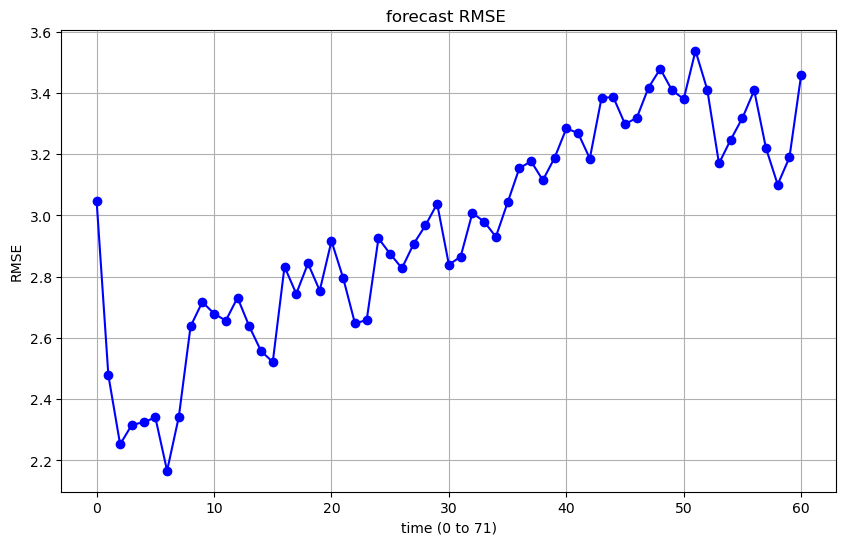

In [403]:
# step4: 模型预测
X = np.nan_to_num(X, nan=0.0)
# 注意由于 model.add(Dense(25)) 加入了全连接层，最后一步对每个时间输出25维结果，所以暂时取出第一个维度的数据
X_pred = loaded_model.predict(X)
X_fit_random=X_pred[:,:,0]
X_fit_random.shape

X_denormalize=scaler_X.inverse_transform(X_fit_random)


X_denormalize=X_denormalize.T
y_denormalize=split_df_realdata

# 计算差值的平方
squared_errors = (X_denormalize - y_denormalize)**2

# 计算每列的均方误差 (MSE)
mse_per_column = squared_errors.mean(axis=1) # axis=0 表示按列计算均值

# 计算每列的均方根误差 (RMSE)
rmse = np.sqrt(mse_per_column)

plt.figure(figsize=(10,6))
plt.plot(rmse.index, rmse.values, marker='o', linestyle='-', color='blue')
plt.xlabel('time (0 to 71)')
plt.ylabel('RMSE')
plt.title('forecast RMSE ')
plt.grid(True)
plt.show()

In [435]:
#### step2: 求`realdata`与`原始预报`数据的`RMSE`  

# 计算差值的平方
squared_errors_or = (split_df_forecast - split_df_realdata)**2

# 计算每列的均方误差 (MSE)
mse_per_column_or = squared_errors_or.mean(axis=1) # axis=0 表示按列计算均值

# 计算每列的均方根误差 (RMSE)
rmse_or = np.sqrt(mse_per_column_or)
print(rmse_or)



0     1.461068
1     1.499241
2     1.498884
3     1.770567
4     1.629761
        ...   
56    3.998855
57    3.704116
58    4.162070
59    3.925614
60    4.288857
Length: 61, dtype: float64


In [436]:
# 求`realdata`与`模型预测`数据的`RMSE`  

# 计算差值的平方
mse_pr = np.mean((y_test_real - y_pred_real) ** 2, axis=0)  # 计算每列的MSE
rmse_real_pr = np.sqrt(mse_pr)

print(rmse_real_pr)
# squared_errors_pr = (y_pred_real - split_df_realdata)**2

# # 计算每列的均方误差 (MSE)
# mse_per_column_pr = squared_errors_pr.mean(axis=1) # axis=0 表示按列计算均值

# # 计算每列的均方根误差 (RMSE)
# rmse_pr = np.sqrt(mse_per_column_pr)

[3.14191545 2.55256249 2.36898084 2.4621541  2.39312783 2.38257325
 2.31450791 2.49762118 2.72975071 2.78844973 2.81053781 2.8099478
 2.85913923 2.75933336 2.73909726 2.71906573 2.98613112 2.90315009
 3.04516391 2.98590707 3.11676272 3.00627479 2.93238365 2.96620157
 3.17302344 3.12737007 3.13857284 3.21622405 3.2429102  3.29225077
 3.16980653 3.19434038 3.3078326  3.28671053 3.30376177 3.39556276
 3.48999296 3.50958026 3.52613426 3.5823087  3.65111344 3.62835577
 3.59947543 3.75981504 3.74950396 3.67963368 3.73404415 3.8167873
 3.85509224 3.78948029 3.79212793 3.90127074 3.77451017 3.58779495
 3.70972717 3.78948492 3.85676134 3.72181367 3.66949032 3.70384105
 3.83285476]


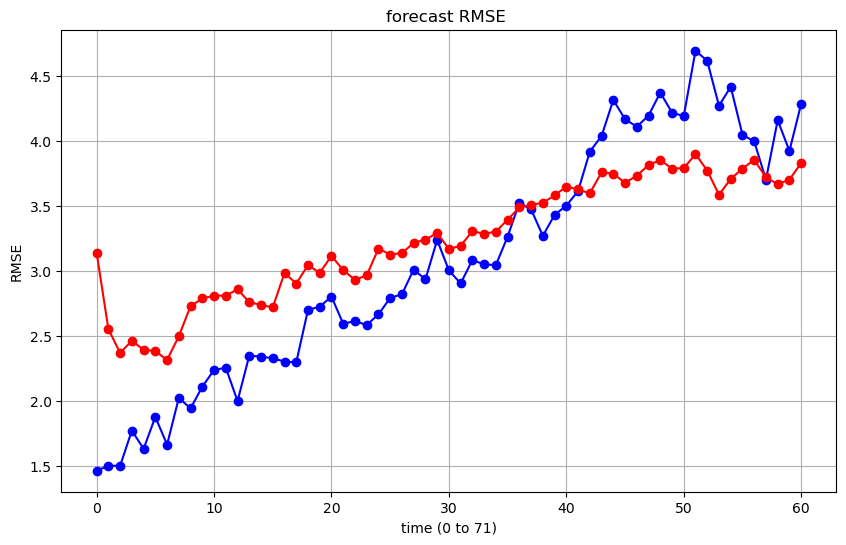

In [437]:

#计算实际数值与预测数值之间的RMSE
plt.figure(figsize=(10,6))
plt.plot(split_df_forecast.index, rmse_or.values, marker='o', linestyle='-', color='blue')
plt.plot(split_df_forecast.index, rmse_real_pr, marker='o', linestyle='-', color='red')
plt.xlabel('time (0 to 71)')
plt.ylabel('RMSE')
plt.title('forecast RMSE ')
plt.grid(True)
plt.show()


In [438]:
print(y_pred_real)
print(y_test_real)
print(y_pred_real.shape)
print(y_test_real.shape)
print(split_df_realdata)

[[8.398171  9.407283  9.591759  ... 7.298967  6.8821006 6.2566476]
 [4.2871313 4.379457  4.4737473 ... 6.2516923 5.8621993 5.3510494]
 [4.8735514 5.6709046 6.1300745 ... 4.8653636 4.7516603 4.59461  ]
 ...
 [6.1462812 6.665788  6.9498706 ... 8.381469  7.944575  7.1624007]
 [5.433995  6.6120977 7.8057413 ... 6.839719  6.315179  5.692837 ]
 [6.754008  7.3897905 7.4948506 ... 8.650107  8.070936  7.2132435]]
[[15.6 16.1 13.7 ...  8.4 15.2 14.6]
 [ 7.3  1.9  1.5 ... 13.   9.7  8.7]
 [ 4.6  5.5  6.8 ...  5.7  3.5  1.7]
 ...
 [ 9.7  5.6  7.5 ...  0.1  0.1  0.1]
 [ 1.7  4.8 10.  ...  0.1  0.1  0.1]
 [12.   8.8  0.1 ...  0.1  0.1  0.1]]
(147, 61)
(147, 61)
    2024-10-19 12:00:00  2024-10-20 00:00:00  2024-10-20 12:00:00  \
0                  15.6                  7.3                  4.6   
1                  16.1                  1.9                  5.5   
2                  13.7                  1.5                  6.8   
3                  11.4                  1.0                  5.9   

In [439]:
model_path: str = r'G:\05DATA\02MODELS\fit_model_250603.h5'
loaded_model = load_customer_model(model_path)

# 实况拼接有问题需要手动去掉最后一列
df_realdata = df_realdata.drop(df_realdata.columns[-1], axis=1)
print(f'df_forecast.shape: {df_forecast.shape}')
print(f'df_realdata.shape: {df_realdata.shape}')
pass
# step2: 由于数据中存在nan，如何处理nan
pass
# step3: 数据标准化(提出nan值)
rows: int = df_forecast.shape[0]
cols: int = df_forecast.shape[1]
# TODO:[-] 25-05-28 注意原始数据中: forecast (72,732), real (72,733)
X = df_forecast.values.T.reshape(cols, rows, 1)
# TODO:[*] 25-05-11 注意 y 中有存在 nan
# ValueError: cannot reshape array of size 52776 into shape (732,72,1)
y = df_realdata.values.T.reshape(cols, rows, 1)
# step3-2:对数据进行归一化
# 拍扁数据为二维数组（n*timesteps, feature）进行归一化
X_flat = X.reshape(-1, 1)
y_flat = y.reshape(-1, 1)
# 分别为 X 和 y 定义归一化器（当然如果两者量纲一致，可用同一个 scaler）
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X_flat)
y_scaled = scaler_y.fit_transform(y_flat)
# 将归一化后的二维数据恢复为原来的3D形状
X = X_scaled.reshape(X.shape)
y = y_scaled.reshape(y.shape)
# step3-3: 对数据集进行划分
# 拆分数据集为训练集和测试集
# 此处 *_tran 均为 (585,72,1) | *_test 均为 (147,72,1)
# X_* 相当于是 预报数据集 | y_* 是实况(验证)数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 此处加入转换
X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)
# step4: 模型预测
X_train = np.nan_to_num(X_train, nan=0.0)
X_test = np.nan_to_num(X_test, nan=0.0)
y_train = np.nan_to_num(y_train, nan=0.0)
y_test = np.nan_to_num(y_test, nan=0.0)
# 注意由于 model.add(Dense(25)) 加入了全连接层，最后一步对每个时间输出25维结果，所以暂时取出第一个维度的数据
y_pred = loaded_model.predict(X_test)
y_pred = y_pred[:, :, 0]
# 反归一化
# ERROR: ValueError: Found array with dim 3. None expected <= 2.
y_pred_real = scaler_y.inverse_transform(y_pred)
y_test = y_test[:, :, 0]
y_test_real = scaler_y.inverse_transform(y_test)
rmse_real = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
# 真实数据上的 RMSE: 4.6269
print(f'真实数据上的 RMSE: {rmse_real:.4f}')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 72, 1)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 72, 256)          133120    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 72, 256)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 72, 128)          164352    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 72, 128)           0         
                                                                 
 dense (Dense)               (None, 72, 25)            3

ValueError: cannot reshape array of size 44591 into shape (732,72,1)

In [ ]:
print(y_test_real)
print(X_test)

[[ 5.8        7.1        8.5       ...  7.2999997  7.7999997  8.4      ]
 [ 0.3        2.9        4.9       ... 15.        14.200001  14.6      ]
 [ 7.7        7.         5.5       ...  3.         2.9        2.       ]
 ...
 [ 4.7        5.8        6.9       ...  4.1        3.2        2.2      ]
 [ 0.3        2.6        2.6       ...  3.9999998  3.5        5.2      ]
 [ 2.3        2.2        2.5000002 ...  9.599999   7.5        7.1      ]]
[[[0.26541862]
  [0.38863605]
  [0.40757748]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.18056248]
  [0.4489762 ]
  [0.5656122 ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.34033486]
  [0.4302699 ]
  [0.3649483 ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 ...

 [[0.40051407]
  [0.3032063 ]
  [0.3136645 ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.22908229]
  [0.19507855]
  [0.02604533]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.07420642]
  [0.14732671]
  [0.17435221]
  ...
  [0.    

In [ ]:
df_forecast.head()

,2024-01-01 00:00:00,2024-01-01 12:00:00,2024-01-02 00:00:00,2024-01-02 12:00:00,2024-01-03 00:00:00,2024-01-03 12:00:00,2024-01-04 00:00:00,2024-01-04 12:00:00,2024-01-05 00:00:00,2024-01-05 12:00:00,...,2024-12-27 00:00:00,2024-12-27 12:00:00,2024-12-28 00:00:00,2024-12-28 12:00:00,2024-12-29 00:00:00,2024-12-29 12:00:00,2024-12-30 00:00:00,2024-12-30 12:00:00,2024-12-31 00:00:00,2024-12-31 12:00:00
0,2.923878,9.315406,5.012707,3.827535,7.922782,7.508249,10.098755,6.931345,7.173455,5.142837,...,8.743365,8.087823,6.933784,5.954374,5.939341,9.051125,6.255262,10.815748,2.710204,11.655143
1,6.530825,10.155370,3.986798,3.946773,5.445124,9.135552,9.633334,9.233833,3.393676,6.577634,...,8.122977,9.979736,8.622316,6.085054,8.969516,9.038375,7.546649,8.284430,5.122671,10.364008
2,8.889989,9.057070,3.408297,4.889753,3.289932,9.488909,10.207234,10.298507,1.344447,7.846056,...,7.816586,8.706822,9.970959,4.476284,11.169362,8.924077,8.936747,9.210247,9.479596,7.171209
3,9.039523,6.656440,4.539793,8.769405,4.212557,10.969419,8.871683,10.377746,4.269206,8.143950,...,7.456558,8.165563,7.588914,5.417556,11.360951,8.352539,10.649641,7.110746,10.821920,8.756545
4,8.654149,4.121097,4.043969,7.281161,7.424704,11.250175,8.345333,6.764350,6.505871,9.279316,...,8.452628,9.429845,5.237637,7.014868,10.349231,7.226018,10.895060,2.116098,11.402069,8.556267


In [ ]:
df_realdata.head()

,2024-01-01 00:00:00,2024-01-01 12:00:00,2024-01-02 00:00:00,2024-01-02 12:00:00,2024-01-03 00:00:00,2024-01-03 12:00:00,2024-01-04 00:00:00,2024-01-04 12:00:00,2024-01-05 00:00:00,2024-01-05 12:00:00,...,2024-12-27 12:00:00,2024-12-28 00:00:00,2024-12-28 12:00:00,2024-12-29 00:00:00,2024-12-29 12:00:00,2024-12-30 00:00:00,2024-12-30 12:00:00,2024-12-31 00:00:00,2024-12-31 12:00:00,Unnamed: 0
0,4.0,12.8,4.5,2.4,8.8,9.1,11.8,9.1,4.7,5.6,...,8.8,9.5,5.7,7.2,8.5,8.2,9.7,1.7,12.0,NaN
1,5.3,11.1,4.4,2.5,7.0,9.7,10.9,8.8,4.1,4.9,...,9.4,9.2,5.0,7.6,8.9,7.5,8.3,1.6,10.8,1.0
2,6.4,9.9,NaN,3.9,6.4,10.8,10.4,8.5,3.8,6.6,...,10.6,8.0,5.4,6.4,7.8,6.4,6.3,2.1,9.3,2.0
3,NaN,9.3,NaN,4.6,NaN,9.6,NaN,7.5,NaN,6.5,...,9.2,7.1,5.3,9.5,8.9,7.6,5.6,4.8,8.8,3.0
4,8.1,10.4,1.5,2.7,5.5,9.8,8.2,6.7,0.8,7.4,...,8.4,6.5,4.8,10.2,8.8,7.2,8.1,7.6,NaN,4.0


In [ ]:
df_realdata.iloc[:24, :]

,2024-01-01 00:00:00,2024-01-01 12:00:00,2024-01-02 00:00:00,2024-01-02 12:00:00,2024-01-03 00:00:00,2024-01-03 12:00:00,2024-01-04 00:00:00,2024-01-04 12:00:00,2024-01-05 00:00:00,2024-01-05 12:00:00,...,2024-12-27 12:00:00,2024-12-28 00:00:00,2024-12-28 12:00:00,2024-12-29 00:00:00,2024-12-29 12:00:00,2024-12-30 00:00:00,2024-12-30 12:00:00,2024-12-31 00:00:00,2024-12-31 12:00:00,Unnamed: 0
0,4.0,12.8,4.5,2.4,8.8,9.1,11.8,9.1,4.7,5.6,...,8.8,9.5,5.7,7.2,8.5,8.2,9.7,1.7,12.0,NaN
1,5.3,11.1,4.4,2.5,7.0,9.7,10.9,8.8,4.1,4.9,...,9.4,9.2,5.0,7.6,8.9,7.5,8.3,1.6,10.8,1.0
2,6.4,9.9,NaN,3.9,6.4,10.8,10.4,8.5,3.8,6.6,...,10.6,8.0,5.4,6.4,7.8,6.4,6.3,2.1,9.3,2.0
3,NaN,9.3,NaN,4.6,NaN,9.6,NaN,7.5,NaN,6.5,...,9.2,7.1,5.3,9.5,8.9,7.6,5.6,4.8,8.8,3.0
4,8.1,10.4,1.5,2.7,5.5,9.8,8.2,6.7,0.8,7.4,...,8.4,6.5,4.8,10.2,8.8,7.2,8.1,7.6,NaN,4.0
5,9.3,10.4,1.2,3.0,3.1,9.8,8.9,5.9,2.1,5.9,...,8.3,7.7,4.8,11.3,8.7,5.0,8.6,9.1,NaN,5.0
6,10.6,10.8,1.7,2.7,1.2,9.4,6.8,7.2,2.4,5.9,...,7.6,7.7,4.5,11.2,10.8,3.9,7.5,10.0,NaN,6.0
7,9.8,10.1,1.7,3.8,1.3,10.3,8.8,8.8,3.5,5.9,...,7.4,8.1,5.2,11.8,11.5,4.2,7.0,11.0,NaN,7.0
8,11.3,9.4,2.6,3.6,3.4,10.9,8.7,10.1,3.8,7.9,...,6.8,7.5,5.1,11.0,10.6,4.2,5.7,10.7,NaN,8.0
9,11.9,8.6,2.8,6.1,5.8,11.7,8.2,8.4,3.9,6.6,...,7.6,7.0,6.6,11.1,10.3,3.7,4.8,12.5,NaN,9.0


#### step2: 求`预报`与`实况`数据的`RMSE`  
此处计算有问题

In [ ]:
df_realdata.shape

(72, 733)

In [ ]:
# 计算差值的平方
squared_errors = (df_forecast - df_realdata)**2

# 计算每列的均方误差 (MSE)
mse_per_column = squared_errors.mean(axis=0) # axis=0 表示按列计算均值

# 计算每列的均方根误差 (RMSE)
rmse = np.sqrt(mse_per_column)



In [ ]:
overall_mean_rmse=rmse.mean()

In [ ]:
print("所有列 RMSE 的均值:", overall_mean_rmse)

所有列 RMSE 的均值: 4.376266045516178


In [ ]:
# rmse_per_column 现在是一个 Pandas Series，索引是列名，值是对应的RMSE
print(rmse_per_column)
print(rmse_per_column.shape) # 输出应该是 (733,)

2024-01-01 00:00:00    4.835064
2024-01-01 12:00:00    5.371533
2024-01-02 00:00:00    4.120010
2024-01-02 12:00:00    3.965389
2024-01-03 00:00:00    3.850253
                         ...   
2024-12-30 00:00:00    3.292449
2024-12-30 12:00:00    4.134972
2024-12-31 00:00:00    5.627513
2024-12-31 12:00:00    1.100302
Unnamed: 0                  NaN
Length: 733, dtype: float64
(733,)


#### step3: 按照[0,24],[24,48],[48,72] 划分进行RMSE的评估

In [ ]:
df_realdata_24= df_realdata.iloc[:24, :]
df_forecast_24= df_forecast.iloc[:24, :]

In [ ]:
df_realdata_24.shape

(24, 733)

In [ ]:
# 计算差值的平方
squared_errors = (df_forecast_24 - df_realdata_24)**2

# 计算每列的均方误差 (MSE)
mse_per_column = squared_errors.mean(axis=1) # axis=0 表示按列计算均值

# 计算每列的均方根误差 (RMSE)
rmse = np.sqrt(mse_per_column)
print("所有[0,24]列 RMSE 的均值:", rmse)

所有[0,24]列 RMSE 的均值: 0     1.662859
1     2.013947
2     2.582090
3     2.956203
4     3.341247
5     3.576843
6     3.626434
7     3.755791
8     3.989735
9     4.143391
10    4.175177
11    4.325491
12    4.409351
13    4.681849
14    4.734400
15    4.567023
16    4.573719
17    4.579885
18    4.629018
19    4.675626
20    4.871207
21    4.894434
22    4.900174
23    5.041708
dtype: float64


如上输出的结果可知: 预报时效随着预报时长的增加，均方根误差在增大  
从你打印的结果可以观察到以下几点结论：

1. **预报误差存在累积效应**  
   可以看到，当预报时效从 0 小时时（即对应第一行 RMSE 值约为 1.66）逐渐增加到 23 小时（即最后一行 RMSE 值约为 5.04）时，RMSE 值整体呈现上升趋势。这说明随着预报时间（时效）的增长，误差会不断累积，导致后期预报的不确定性加大，这与大多数气象预报系统的表现是相符的。

2. **短时预报准确性较高，长时预报误差较大**  
   从 RMSE 随着预报时效的增长增大来看，短时预报（比如前几小时）的 RMSE 较低，预报值与实际值比较接近；而长时预报（比如20小时以后）的 RMSE 较高，说明预测结果与观测之间的差距在扩大。这反映了模型在近时预报上具有较高的准确性，而在较长时效的预报上不确定性较大。

3. **细化时效段评估有助于发现模型性能差异**  
   通过依次计算每个时效步长（0 至 23 小时）的 RMSE，我们可以详细观察模型在不同预报时效下的表现。如果将所有这些 RMSE 值再求平均，则可以获得一个总体的 24 小时预报均值指标，但更细致地观察各个时效的 RMSE 可以帮助我们定位模型在哪些预测时段表现突出或不足，是进一步改进和优化模型的重要依据。

总体而言，从这些 RMSE 数值可以得出结论： **预报系统在非常短时的预报上表现较好，但随着预报时效延长，预测误差逐渐放大，预报不确定性增加。** 这种趋势在风场预报和其他气象预报中都比较常见，并可以用于指导模型的改进和后续误差校正工作。

你是否还希望探讨在这种预报评估下如何进一步分解误差来源或引入其他指标（如 MAE 或 bias）来更全面地评估模型性能？

In [ ]:
# 计算差值的平方
squared_errors = (df_forecast_24 - df_realdata_24)**2

# 计算每列的均方误差 (MSE)
mse_per_column = squared_errors.mean(axis=0) # axis=0 表示按列计算均值

# 计算每列的均方根误差 (RMSE)
rmse = np.sqrt(mse_per_column)
rmse

2024-01-01 00:00:00    5.369119
2024-01-01 12:00:00    6.414488
2024-01-02 00:00:00    4.536756
2024-01-02 12:00:00    3.388340
2024-01-03 00:00:00    4.780276
                         ...   
2024-12-30 00:00:00    2.675565
2024-12-30 12:00:00    4.082101
2024-12-31 00:00:00    5.627513
2024-12-31 12:00:00    1.100302
Unnamed: 0                  NaN
Length: 733, dtype: float64

In [ ]:
rmse.mean()

3.8087684835156104

#### step5: 查看 48小时 以及 72小时的 `RMSE`

In [ ]:
df_realdata_48= df_realdata.iloc[24:48, :]
df_forecast_48= df_forecast.iloc[24:48, :]
# 计算差值的平方
squared_errors = (df_realdata_48 - df_forecast_48)**2

# 计算每列的均方误差 (MSE)
mse_per_column = squared_errors.mean(axis=1) # axis=0 表示按列计算均值

# 计算每列的均方根误差 (RMSE)
rmse = np.sqrt(mse_per_column)
rmse

24    5.008605
25    4.972983
26    4.886079
27    4.704657
28    4.874237
29    4.869993
30    4.822714
31    4.785894
32    4.804805
33    4.828537
34    4.818969
35    4.886673
36    4.916128
37    4.927859
38    4.881686
39    4.738392
40    4.919237
41    4.845160
42    4.992273
43    4.831158
44    4.813863
45    4.923342
46    4.912902
47    4.863056
dtype: float64

In [ ]:
df_realdata_72= df_realdata.iloc[48:72, :]
df_forecast_72= df_forecast.iloc[48:72, :]
# 计算差值的平方
squared_errors = (df_realdata_72 - df_forecast_72)**2

# 计算每列的均方误差 (MSE)
mse_per_column = squared_errors.mean(axis=1) # axis=0 表示按列计算均值

# 计算每列的均方根误差 (RMSE)
rmse = np.sqrt(mse_per_column)
rmse

48    4.962224
49    5.085507
50    5.172347
51    4.876797
52    4.967780
53    4.769545
54    4.934040
55    4.831923
56    4.999050
57    4.953005
58    5.018070
59    5.030597
60    4.934910
61         NaN
62         NaN
63         NaN
64         NaN
65         NaN
66         NaN
67         NaN
68         NaN
69         NaN
70         NaN
71         NaN
dtype: float64

从计算结果中，可以归纳出以下几点结论和思考，在比较不同预报时效段的RMSE后，这些信息有助于理解预报模型的性能和数据现状：

1. **预报时效增长与误差累积的趋势**  
   - 在第一个时效段（对应0至24小时的数据）：从最初的预报（第0小时，RMSE≈1.66）到预报末时（第23小时，RMSE≈5.04），RMSE呈现出明显的上升趋势。这说明预报误差会随着预报时效的增长而累积，不仅仅因为误差传递，还可能反映出模型对后期状态的不确定性增大。  
   - 对于第二个时效段（`iloc[24:48]`，得到的一系列结果，其索引从0到23显示的是对应每个小时的误差）：结果同样显示预报时效越长，预报误差越大。这个趋势在数值上与0~24小时段类似，只是总体平均水平可能已经提高。

2. **长时预报中部分数据缺失的问题**  
   - 对于第三个时效段（对应48至72小时的数据），你计算RMSE时，结果显示前部分有比较稳定的数值（例如索引48到60的RMSE大约在4.9至5.0左右），但从索引61开始直至71，均计算出NaN。这一现象说明在这些时刻可能存在实际观测数据缺失或无效的情况，使得RMSE无法计算。
   - 这种数据缺失可能是因为：
     - 实际观测数据只覆盖到某一时刻，超出这一范围的部分无法进行验证；
     - 或者该时段内原始数据预处理时被剔除了（如异常值较多被置为NaN）。
     
   数据缺失会使得我们对长时预报的误差评估存在局限性，这需要在数据采集和预处理上进一步核查。

3. **预报不确定性和模型性能评估的启示**  
   - 总体来看，从短时预报到长时预报，RMSE呈现出逐渐增大的趋势，这是多数数值预报系统中常见的现象，表明随着预报时效延长，模型预测的不确定性越大。
   - 对于改进模型或预报系统来说：
     - 短时段（0~24小时）的预报已经较为准确，这部分可以作为模型基准；
     - 中时段（24~48小时）和长时段（48~72小时）中，误差明显增大，也许需要针对性地优化物理过程、数据同化或预报方法；
     - 同时，长时预报中存在的NaN状况提醒我们检查数据完整性与后续验证机制，确保数据覆盖足够支撑对模型长期预报性能的评估。

总之，  
- **误差随预报时效增长**：短时预报较为准确，长时预报误差较大；  
- **部分时段数据缺失问题**：长时预报（48-72小时）部分时刻出现NaN，提示存在实际观测数据不足或预处理的问题。

这些结论不仅有助于认识当前预报模型在不同预报时效下的表现，还为后续模型改进、误差校正与数据完善提供了方向。  

你是否对如何进一步处理长时缺失数据、或者采用其他指标（如MAE、偏差等）来综合评价预报性能有更多的兴趣呢？

In [ ]:
# 计算差值的平方
squared_errors = (df_forecast - df_realdata)**2

# 计算每列的均方误差 (MSE)
mse_per_column = squared_errors.mean(axis=1) # axis=0 表示按列计算均值

# 计算每列的均方根误差 (RMSE)
rmse = np.sqrt(mse_per_column)
rmse

0     1.662859
1     2.013947
2     2.582090
3     2.956203
4     3.341247
        ...   
67         NaN
68         NaN
69         NaN
70         NaN
71         NaN
Length: 72, dtype: float64

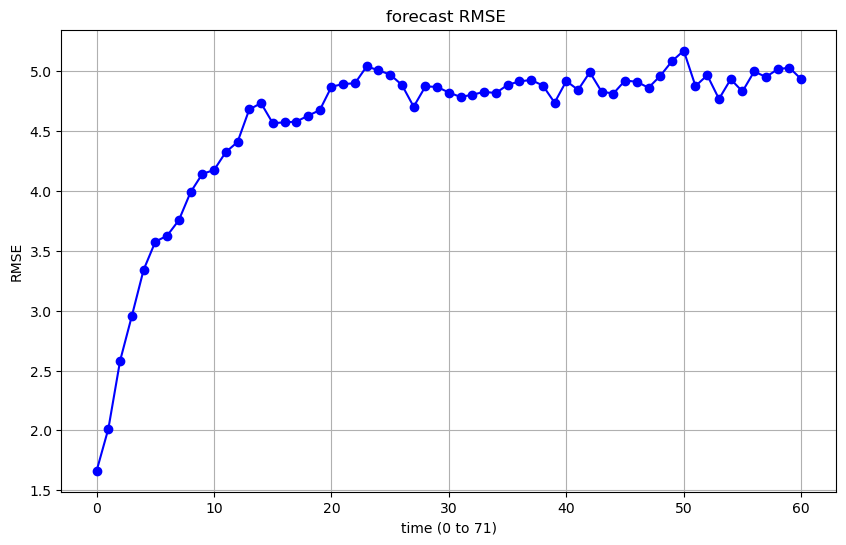

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(rmse.index, rmse.values, marker='o', linestyle='-', color='blue')
plt.xlabel('time (0 to 71)')
plt.ylabel('RMSE')
plt.title('forecast RMSE ')
plt.grid(True)
plt.show()

#### step6: 计算MAE以及偏差

In [ ]:
# 计算误差：预测值与实际值的差值
error = df_forecast - df_realdata

# 计算每一列的 MAE
mae_per_column = np.abs(error).mean(axis=1)

# 计算每一列的 Bias
bias_per_column = error.mean(axis=1)

# 如果需要，可以计算所有列 MAE 或 Bias 的均值作为整体指标
overall_mean_mae = mae_per_column.mean()
overall_mean_bias = bias_per_column.mean()


In [ ]:
print("每列 MAE:")
print(mae_per_column)
print("所有列 MAE 的均值:", overall_mean_mae)

每列 MAE:
0     1.315412
1     1.537702
2     1.942189
3     2.211387
4     2.532701
        ...   
67         NaN
68         NaN
69         NaN
70         NaN
71         NaN
Length: 72, dtype: float64
所有列 MAE 的均值: 3.563169011107653


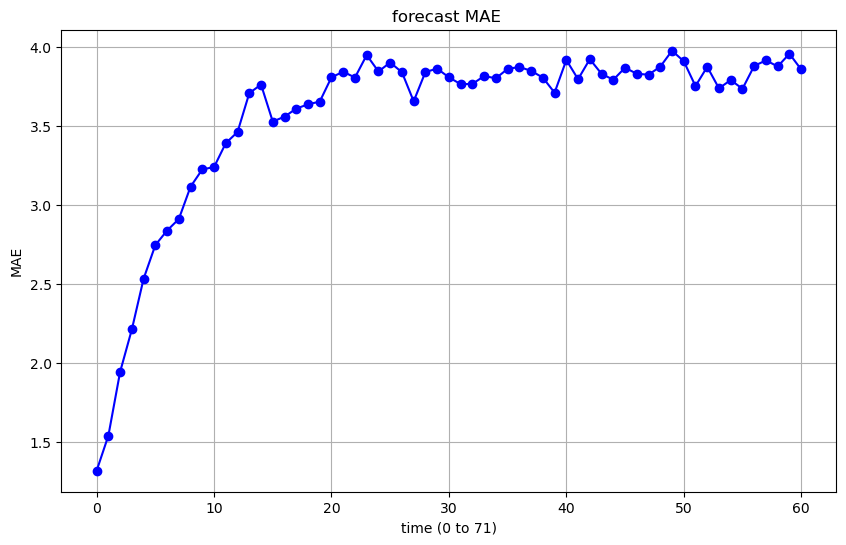

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(mae_per_column.index, mae_per_column.values, marker='o', linestyle='-', color='blue')
plt.xlabel('time (0 to 71)')
plt.ylabel('MAE')
plt.title('forecast MAE ')
plt.grid(True)
plt.show()

In [ ]:
print("每列 Bias:")
print(bias_per_column)
print("所有列 Bias 的均值:", overall_mean_bias)

每列 Bias:
0     0.146593
1     0.342671
2     0.337135
3     0.275822
4     0.121570
        ...   
67         NaN
68         NaN
69         NaN
70         NaN
71         NaN
Length: 72, dtype: float64
所有列 Bias 的均值: 0.05195199148354405


In [ ]:
bias_per_column.tolist()

[0.14659264966415114,
 0.3426706571654673,
 0.33713474385793396,
 0.27582230609579783,
 0.12156985835141215,
 0.345781078136788,
 0.16518114527031563,
 0.017601930309714454,
 0.1898193368307309,
 0.3770846310523737,
 0.10999946217401942,
 -0.035157742915884214,
 -0.030343636474579862,
 0.02311034559527518,
 0.09443327428958836,
 0.007783788297681521,
 -0.07381297327537242,
 0.10440122556408163,
 0.09509527359960761,
 -0.0693672170143733,
 0.07711802994350135,
 0.18728752445909097,
 0.03133371953360634,
 -0.012896527960009549,
 0.04159503966113734,
 0.07489880929872227,
 0.03786629994181996,
 0.07389313593703555,
 -0.028227281877174076,
 0.0762296332708909,
 0.0818671460858398,
 -0.018044130823878568,
 0.19517143543425317,
 0.251730162769702,
 0.061219555256883065,
 -0.021303529543711695,
 -0.02313268269552925,
 -0.026041141999115,
 -0.20593474120029218,
 -0.047000708480532664,
 -0.06762311127037447,
 -0.23155217485422916,
 -0.04347099949054808,
 -0.08553595974710991,
 -0.11521294439711

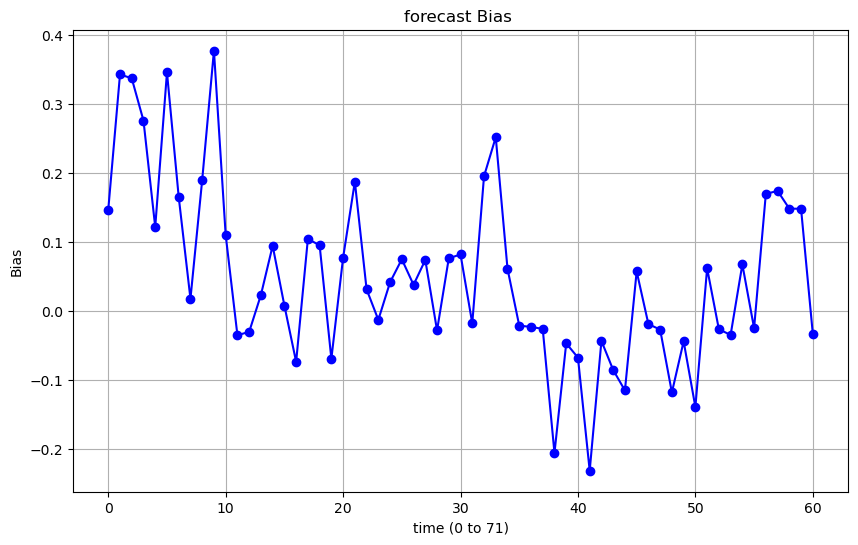

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(bias_per_column.index, bias_per_column.values, marker='o', linestyle='-', color='blue')
plt.xlabel('time (0 to 71)')
plt.ylabel('Bias')
plt.title('forecast Bias ')
plt.grid(True)
plt.show()